### Setup

Below setup code is mainly from the ConvolutionalVAE notebook from week 4

In [58]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers.legacy import Adam

from keras.layers import Lambda, Input, Dense
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.layers import Reshape, Flatten, BatchNormalization, Activation

from keras.models import Model
from keras.losses import mse, binary_crossentropy

from keras import backend as K


In [59]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

### Importing datasets

Import the villagers images dataset

Import the villagers information dataset

In [4]:
directory = "villagers"

img_files = []
img_files += [os.path.join(directory, img) for img in os.listdir(directory)]

#print(img_files)

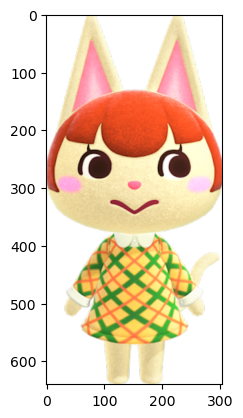

In [5]:
img = plt.imread(img_files[88])
plt.imshow(img)

### Processing of data

-ChatGPT help

In [6]:
# Resize the images
villagers_imgs = []
height = 640
width = 400

for file in img_files:
    
    #skip bc of weird file
    if(file==(directory + "/.DS_Store")):
        continue
    
    #plt.figure()
    img = plt.imread(file)
    img = cv2.resize(img, (width, height))
    #print(img.shape)
    #plt.imshow(img)
    #plt.plot()
    
    villagers_imgs.append(img)

villagers_array = np.array(villagers_imgs)

### Creating train and test sets 



(313, 640, 400, 4)
(79, 640, 400, 4)


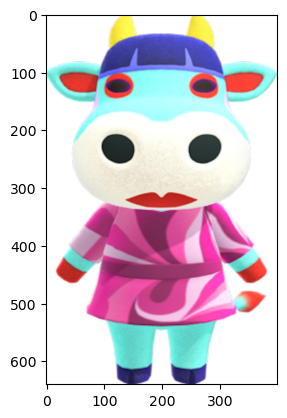

In [7]:
X_train, X_test = train_test_split(villagers_array, test_size=0.2)

print(X_train.shape)
print(X_test.shape)

plt.imshow(X_test[1])


In [8]:
#X_train = X_train.astype('float32') / 255.
#X_test = X_test.astype('float32') / 255.

print(X_train.shape)
print(X_test.shape)

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(X_train.shape)
print(X_test.shape)

(313, 640, 400, 4)
(79, 640, 400, 4)
(313, 1024000)
(79, 1024000)


### Building a simple autoencoder as a start

Using this tutorial from keras "Let's build the simplest possible autoencoder": https://blog.keras.io/building-autoencoders-in-keras.html

In [28]:
encoding_dim = 64
#input_shape = (640, 400, 4)
input_shape=(1024000,)

epochs = 50
batch_size = 64

inputs = Input(shape=input_shape)

encoded = Dense(encoding_dim, activation='relu')(inputs)
decoded = Dense(input_shape[0], activation='sigmoid')(encoded)

# input -> reconstruction 
autoencoder = Model(inputs, decoded)
print(decoded.shape)

# Encoder
# input -> encoded representation
encoder = Model(inputs, encoded)

# Decoder
encoded_input = Input(shape=encoding_dim)

# last layer of autoencoder model
decoder_layer = autoencoder.layers[-1]

# Create decoder model
# encoded rep -> reconstruction 
decoder = Model(encoded_input, decoder_layer(encoded_input))

# Compilation
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
print(autoencoder.summary())

# Train
autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, 
                shuffle=True, validation_data=(X_test, X_test))


(None, 1024000)
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1024000)]         0         
                                                                 
 dense_2 (Dense)             (None, 64)                65536064  
                                                                 
 dense_3 (Dense)             (None, 1024000)           66560000  
                                                                 
Total params: 132,096,064
Trainable params: 132,096,064
Non-trainable params: 0
_________________________________________________________________
None


### Visualise results

In [10]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

3/3 [==============================] - 0s 13ms/step


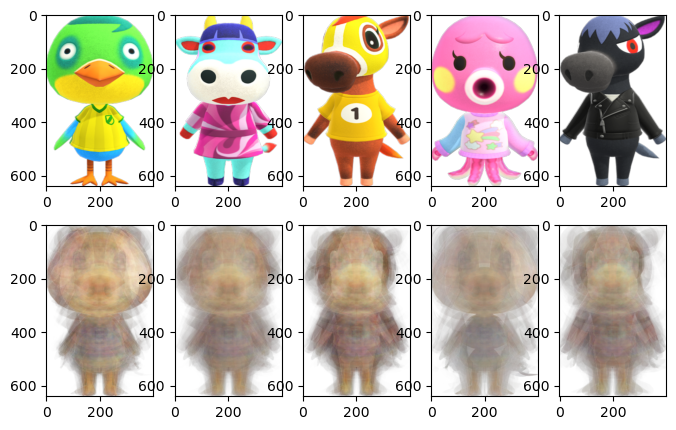

In [11]:
total = 5
plt.figure(figsize=(8, 5))

for i in range(total):
    
    # Original
    ax = plt.subplot(2, total, i+1)
    plt.imshow(X_test[i].reshape(height, width, 4))
    
    # Autoencoder result
    ax = plt.subplot(2, total, i+1+total)
    plt.imshow(decoded_imgs[i].reshape(height, width, 4))

plt.show()

### Some notes on the results

1. Using an encoding_dim value of 32 leads to a loss of 0.4498, and images that aren't so accurate
2. Using an encoding_dim value of 64 leads to a loss of 0.4318 (binary_crossentropy) 

### Convolutional Autoencoder

Using the tutorial from https://blog.keras.io/building-autoencoders-in-keras.html, 'Convolutional Autoencoders'

In [35]:
input_shape = (640, 400, 4)
inputs = Input(shape=input_shape)

# encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(4, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(inputs, decoded)

print(autoencoder.summary())
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 640, 400, 4)]     0         
                                                                 
 conv2d_61 (Conv2D)          (None, 640, 400, 16)      592       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 320, 200, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 320, 200, 8)       1160      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 160, 100, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 160, 100, 8)       584

In [39]:
X_train = X_train.reshape((len(X_train), 640, 400, 4))
X_test = X_test.reshape((len(X_test), 640, 400, 4))

print(X_train.shape)
print(X_test.shape)

(313, 640, 400, 4)
(79, 640, 400, 4)


In [37]:
epochs=50
batch_size=128

autoencoder.fit(X_train, X_train, epochs=epochs, 
                batch_size=batch_size, shuffle=True,
               validation_data=(X_test, X_test))

Epoch 1/50
3/3 [==============================] - 16s 3s/step - loss: 0.6929 - val_loss: 0.6917
Epoch 2/50
3/3 [==============================] - 7s 2s/step - loss: 0.6913 - val_loss: 0.6896
Epoch 3/50
3/3 [==============================] - 7s 2s/step - loss: 0.6888 - val_loss: 0.6855
Epoch 4/50
3/3 [==============================] - 7s 2s/step - loss: 0.6841 - val_loss: 0.6776
Epoch 5/50
3/3 [==============================] - 7s 2s/step - loss: 0.6749 - val_loss: 0.6627
Epoch 6/50
3/3 [==============================] - 7s 2s/step - loss: 0.6582 - val_loss: 0.6371
Epoch 7/50
3/3 [==============================] - 7s 2s/step - loss: 0.6313 - val_loss: 0.6003
Epoch 8/50
3/3 [==============================] - 7s 2s/step - loss: 0.5955 - val_loss: 0.5599
Epoch 9/50
3/3 [==============================] - 7s 2s/step - loss: 0.5562 - val_loss: 0.5097
Epoch 10/50
3/3 [==============================] - 7s 2s/step - loss: 0.5049 - val_loss: 0.4503
Epoch 11/50
3/3 [==============================]

In [42]:
print(X_test.shape)
print(encoded_imgs.shape)
predictions = autoencoder.predict(X_test)

(79, 640, 400, 4)
(79, 64)
3/3 [==============================] - 1s 129ms/step


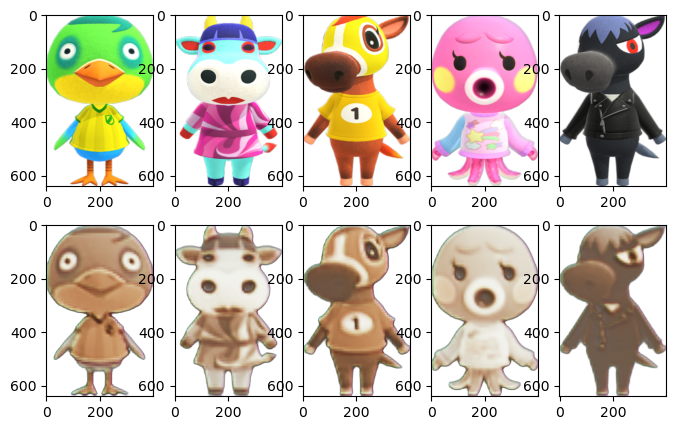

In [43]:
total = 5
plt.figure(figsize=(8, 5))

for i in range(total):
    
    # Original
    ax = plt.subplot(2, total, i+1)
    plt.imshow(X_test[i].reshape(height, width, 4))
    
    # Autoencoder result
    ax = plt.subplot(2, total, i+1+total)
    plt.imshow(predictions[i].reshape(height, width, 4))

plt.show()

### Variational autoencoder 

Using tutorial https://blog.keras.io/building-autoencoders-in-keras.html, 'Variational autoencoder (VAE)' and notebook ConvolutionalVAE from week 4

In [60]:
original_dim = 640 * 400 * 4
intermediate_dim = 64
latent_dim = 2

inputs = Input(shape=(original_dim, ))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)
z = Lambda(sampling)([z_mean, z_log_sigma])

In [61]:
# encoder
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

vae.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 1024000)]         0         
                                                                 
 encoder (Functional)        [(None, 2),               65536324  
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 1024000)           66560192  
                                                                 
Total params: 132,096,516
Trainable params: 132,096,516
Non-trainable params: 0
_________________________________________________________________


In [62]:
reconstruct_loss = binary_crossentropy(inputs, outputs)
reconstruct_loss *= original_dim

kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruct_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [63]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(X_train.shape)
print(X_test.shape)

(313, 1024000)
(79, 1024000)


In [64]:
epochs=100
batch_size=32

vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
        validation_data=(X_test, X_test))

Epoch 1/100


/Users/evahayek/miniforge3/envs/coding3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


10/10 [==============================] - 2s 211ms/step - loss: 838903.3125 - val_loss: 620114.2500
Epoch 2/100
10/10 [==============================] - 2s 157ms/step - loss: 574016.3750 - val_loss: 527397.9375
Epoch 3/100
10/10 [==============================] - 2s 157ms/step - loss: 532235.5625 - val_loss: 501427.2812
Epoch 4/100
10/10 [==============================] - 2s 155ms/step - loss: 522471.0625 - val_loss: 498547.0000
Epoch 5/100
10/10 [==============================] - 2s 156ms/step - loss: 517588.0000 - val_loss: 493841.3438
Epoch 6/100
10/10 [==============================] - 2s 160ms/step - loss: 511496.6875 - val_loss: 488560.5938
Epoch 7/100
10/10 [==============================] - 2s 154ms/step - loss: 506795.9062 - val_loss: 494248.2500
Epoch 8/100
10/10 [==============================] - 2s 156ms/step - loss: 507021.3438 - val_loss: 480922.2812
Epoch 9/100
10/10 [==============================] - 2s 157ms/step - loss: 500158.2500 - val_loss: 478459.2500
Epoch 10/100


10/10 [==============================] - 2s 164ms/step - loss: 456897.7500 - val_loss: 455748.5000
Epoch 75/100
10/10 [==============================] - 2s 163ms/step - loss: 458133.6562 - val_loss: 447311.9688
Epoch 76/100
10/10 [==============================] - 2s 163ms/step - loss: 456700.5938 - val_loss: 448087.1250
Epoch 77/100
10/10 [==============================] - 2s 163ms/step - loss: 454907.7500 - val_loss: 453025.7500
Epoch 78/100
10/10 [==============================] - 2s 163ms/step - loss: 455109.3125 - val_loss: 455728.2812
Epoch 79/100
10/10 [==============================] - 2s 165ms/step - loss: 453887.8125 - val_loss: 455840.3750
Epoch 80/100
10/10 [==============================] - 2s 165ms/step - loss: 451016.8125 - val_loss: 445040.0000
Epoch 81/100
10/10 [==============================] - 2s 164ms/step - loss: 448607.0625 - val_loss: 445477.0312
Epoch 82/100
10/10 [==============================] - 2s 163ms/step - loss: 448781.4375 - val_loss: 446997.4062
Epoch

In [65]:
print(X_test.shape)
print(encoded_imgs.shape)
predictions = vae.predict(X_test)

(79, 1024000)
(79, 64)
3/3 [==============================] - 0s 84ms/step


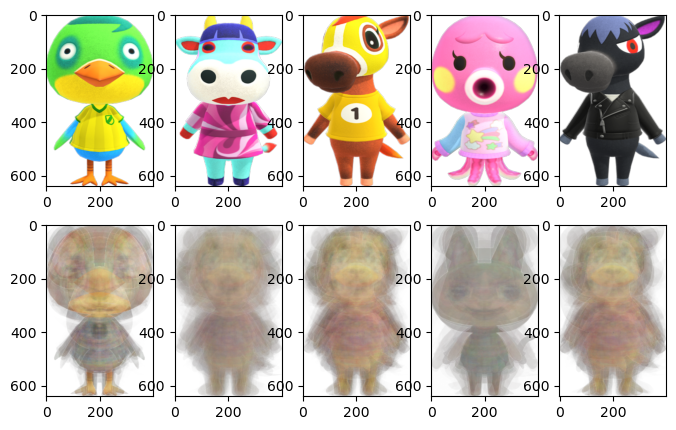

In [66]:
total = 5
plt.figure(figsize=(8, 5))

for i in range(total):
    
    # Original
    ax = plt.subplot(2, total, i+1)
    plt.imshow(X_test[i].reshape(height, width, 4))
    
    # Autoencoder result
    ax = plt.subplot(2, total, i+1+total)
    plt.imshow(predictions[i].reshape(height, width, 4))

plt.show()

### Visualize the latent space



In [69]:
X_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=X_test)
plt.colorbar()
plt.show()

3/3 [==============================] - 0s 45ms/step


TypeError: list indices must be integers or slices, not tuple

<Figure size 600x600 with 0 Axes>